# Basic GP, Marginal Likelihood

This example is to demonstrate use of the gp functionality so far.

In [7]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as tt
import theano.tensor.nlinalg 
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

np.random.seed(205)

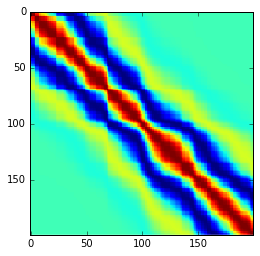

In [8]:
# define gp, true parameter values
with pm.Model() as model:
    l1   = 0.5
    cov1 = pm.gp.cov.Cosine(1, l1)

    l2   = 2
    cov2 = pm.gp.cov.ExpQuad(1, l2)
    
    tau = 2.0
    cov = tau * cov1 * cov2
    
n = 200
X = np.sort(10*np.random.rand(n))[:,None]
K = theano.function([], cov.K(X, X))()

# generate fake data from GP with white noise (with variance sigma2)
sigma2 = 0.2
y = np.random.multivariate_normal(np.zeros(n), K + sigma2 * np.eye(n))

plt.imshow(K,interpolation='none')

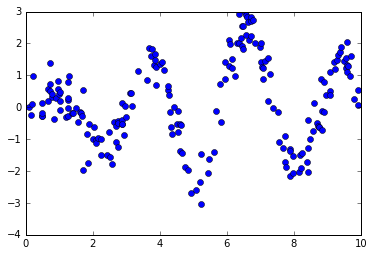

In [9]:
plt.plot(X, y, 'o')

In [10]:
Z = np.linspace(-1, 15, 300)[:,None]

# infer gp parameter values
with pm.Model() as model:
    l1 = pm.Uniform('l1', lower=0.01, upper=1.0)
    l2 = pm.HalfNormal('l2', sd=5)
    sigma2 = pm.HalfNormal('sigma2', sd=5)
    tau = pm.HalfNormal('tau', sd=5)

    
    f_cov1 = pm.gp.cov.Cosine(1, l1)
    f_cov2 = pm.gp.cov.Matern32(1, l2)
    f_cov = tau * (f_cov1 + f_cov2)
    
    n_cov = sigma2 * tt.eye(n)
    
    K   = f_cov.K(X, X) + n_cov

    y_obs = pm.MvNormal('y_obs', mu=0.0, cov=K, observed=y)

    # prediction
    K_inv = tt.nlinalg.matrix_inverse(K)
    K_s  = f_cov.K(X, Z) 
    K_ss = f_cov.K(Z, Z)
    
    mu = pm.Deterministic("mu", tt.dot(tt.dot(K_s.T, K_inv), y))
    Sigma = pm.Deterministic("Sigma", K_ss - tt.dot(tt.dot(K_s.T, K_inv), K_s))

In [11]:
with model:
    start = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
    #print "MAP:", start    
    step = pm.Slice()
    trace = pm.sample(1000, step=step, start=start)

100%|██████████| 1000/1000 [02:30<00:00,  6.46it/s]


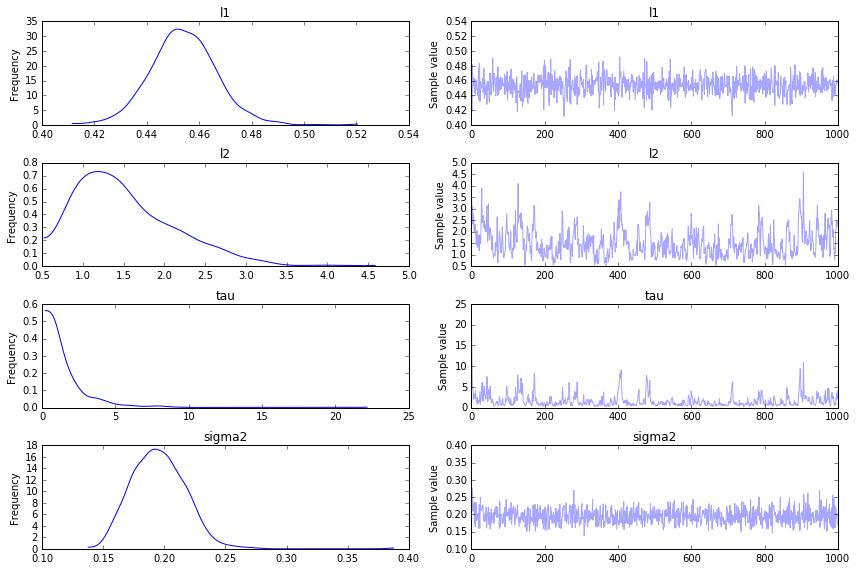

In [14]:
pm.traceplot(trace, varnames=['l1', 'l2', 'tau', 'sigma2']);

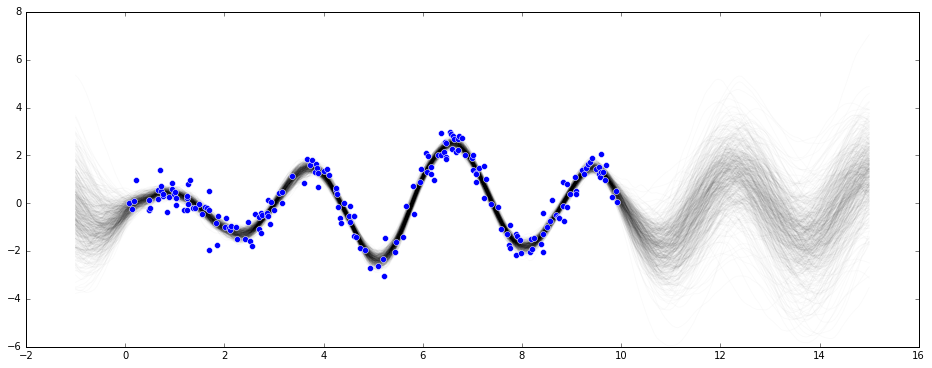

In [15]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(trace['mu'][500:], trace['Sigma'][500:])]

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
for yp in y_pred:
    ax.plot(Z.flatten(), yp, 'k-', alpha=0.05);
ax.plot(X, y, 'o', mec="white")